# Powerlaw DM noise fitting example

This notebook corresponds to Section 6.4 of Susobhanan+ 2024.

In [1]:
from enterprise.pulsar import Pulsar
from enterprise.signals.white_signals import MeasurementNoise
from enterprise.signals.gp_signals import TimingModel
from enterprise.signals.signal_base import PTA
from enterprise_extensions.blocks import dm_noise_block

from pint.models import get_model_and_toas, get_model
from pint.fitter import WLSFitter
from pint.logging import setup as setup_log
from pint.utils import akaike_information_criterion, pldmnoise_from_dmwavex
from pint import DMconst

from PTMCMCSampler.PTMCMCSampler import PTSampler

import numpy as np
import corner
import matplotlib.pyplot as plt
import astropy.units as u
from copy import deepcopy

/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Optional mpi4py package is not installed.  MPI support is not available.


In [2]:
setup_log(level="WARNING")

1

## Estimate the optimal number of harmonics using AIC

In [5]:
# I did an initial fit using pintk. 
# sim4.wx1.par is the result of that. 
m, t = get_model_and_toas("sim4.wx1.par", "sim4.tim")

Tspan = t.get_mjds().max() - t.get_mjds().min()

aics = []
idxs = m.components["DMWaveX"].get_indices()

ftr = WLSFitter(t, m)
ftr.fit_toas(maxiter=3)
aic = akaike_information_criterion(ftr.model, t)
aics += [aic]
print(f"{len(idxs)}\t{aic}\t{ftr.resids.chi2_reduced}")

for idx in reversed(idxs):
    if idx == 1:
        m.remove_component("DMWaveX")
    else:
        m.components["DMWaveX"].remove_dmwavex_component(idx)

    ftr = WLSFitter(t, m)
    ftr.fit_toas(maxiter=3)
    aic = akaike_information_criterion(ftr.model, t)
    aics += [aic]
    print(f"{idx-1}\t{aic}\t{ftr.resids.chi2_reduced}")


45	-52527.09439415978	1.0101922811614787
44	-52530.53950855099	1.0094233939875379
43	-52531.65603596559	1.0098765521622868
42	-52535.14929484174	1.0090843992929295
41	-52537.22912670497	1.0090331437166637
40	-52539.89941596231	1.008673501321279
39	-52543.536360185055	1.007810092539761
38	-52546.977121989206	1.0070507692919861
37	-52549.61697953736	1.0067101656009783
36	-52548.507399553455	1.008321070727253
35	-52552.38029303505	1.0073389836050886
34	-52555.964565442344	1.0065087913026434
33	-52555.767354203796	1.0076416718295866
32	-52559.11979423135	1.0069330068704063
31	-52561.88941275524	1.0065274765714265
30	-52565.378811001836	1.0057506134898653
29	-52569.21601029929	1.004795706194186
28	-52572.09889734581	1.004335190993515
27	-52568.28559782892	1.0073272678671732
26	-52571.78514917987	1.006547553198438
25	-52572.69111931072	1.0071035895990286
24	-52576.30521493703	1.0062668461224087
23	-52578.85369986879	1.0059788488821595
22	-52579.09059032792	1.006876875468367
21	-52578.2832775

In [8]:
aics = np.genfromtxt("sim4-aics.txt")[:,1]

d_aics = np.array(aics) - np.min(aics)
nharm_opt = len(d_aics) - 1 - np.argmin(d_aics)

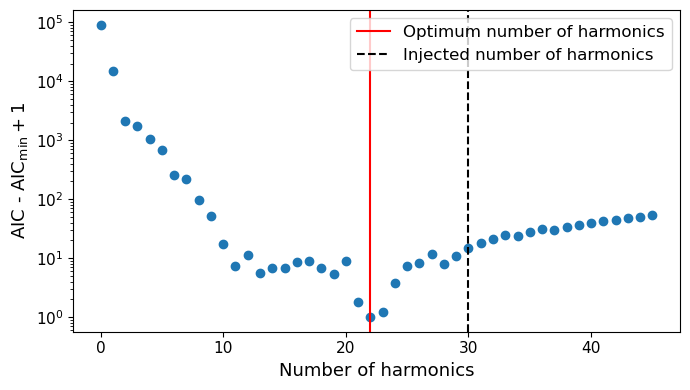

In [14]:
plt.figure(figsize=(7, 4))

plt.scatter(list(reversed(range(len(d_aics)))), d_aics+1)
plt.axvline(nharm_opt, color="red", label="Optimum number of harmonics")
plt.axvline(30, color="black", ls="--", label="Injected number of harmonics")
plt.xlabel("Number of harmonics", fontsize=13)
plt.ylabel("AIC - AIC$_\\min{} + 1$", fontsize=13)
plt.legend(fontsize=12)
plt.yscale("log")
plt.tick_params(axis="both", labelsize=11)
plt.tight_layout()
plt.savefig("sim4-aic.pdf")


## Fit for the DMWaveX parameters

In [15]:
m, t = get_model_and_toas("sim4.wx1.par", "sim4.tim")

Tspan = t.get_mjds().max() - t.get_mjds().min()

idxs = m.components["DMWaveX"].get_indices()
for idx in reversed(idxs):
    if idx > nharm_opt:
        m.components["DMWaveX"].remove_dmwavex_component(idx)

print(m)

# Created: 2024-05-31T15:12:47.156601
# PINT_version: 1.0+232.g3fe7a43e
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-35-generic-x86_64-with-glibc2.35
# Python: 3.9.19 (main, May  6 2024, 19:43:03) 
# [GCC 11.2.0]
# Format: pint
PSR                                  SIM2
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999567023612
FINISH             56985.0000000465617593
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   1870.7912351507534
CHI2R                  0.9825584218228747
TRES                   0.9733732771016129
RAJ                      5:00:00.00000077 1 0.00000190313197381223
DECJ                    15:00:00.00006886 1 0.00016227251111943959
PMRA                                  0.0
PMDEC                  

In [16]:
ftr = WLSFitter(t, m)
ftr.fit_toas(maxiter=5)

print(m)

# Created: 2024-05-31T15:12:48.899676
# PINT_version: 1.0+232.g3fe7a43e
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-35-generic-x86_64-with-glibc2.35
# Python: 3.9.19 (main, May  6 2024, 19:43:03) 
# [GCC 11.2.0]
# Format: pint
PSR                                  SIM2
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999567023612
FINISH             56985.0000000465617593
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   1870.7912351507534
CHI2R                  0.9825584218228747
TRES                   0.9733732771016129
RAJ                      5:00:00.00000077 1 0.00000190313197381223
DECJ                    15:00:00.00006886 1 0.00016227251111943959
PMRA                                  0.0
PMDEC                  

In [17]:
scale = DMconst / (1400 * u.MHz)**2

In [18]:
idxs = np.array(ftr.model.components["DMWaveX"].get_indices())
a = np.array([(scale*ftr.model[f"DMWXSIN_{idx:04d}"].quantity).to_value("s") for idx in idxs])
da = np.array([(scale*ftr.model[f"DMWXSIN_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])
b = np.array([(scale*ftr.model[f"DMWXCOS_{idx:04d}"].quantity).to_value("s") for idx in idxs])
db = np.array([(scale*ftr.model[f"DMWXCOS_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])

In [19]:
P = (a**2 + b**2) / 2
dP = ((a*da)**2 + (b*db)**2)**0.5

In [20]:
m_pint = pldmnoise_from_dmwavex(ftr.model)

P_pint = m_pint.components["PLDMNoise"].get_noise_weights(t)

In [21]:
m_plrn = get_model("sim4.par")
print(m_plrn)

# Created: 2024-05-31T15:12:56.776804
# PINT_version: 1.0+232.g3fe7a43e
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-35-generic-x86_64-with-glibc2.35
# Python: 3.9.19 (main, May  6 2024, 19:43:03) 
# [GCC 11.2.0]
# Format: pint
PSR                                  SIM2
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
DILATEFREQ                              N
DMDATA                                  N
NTOA                                    0
RAJ                      5:00:00.00000000 1 0.00000000000000000000
DECJ                    15:00:00.00000000 1 0.00000000000000000000
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
F0                                  100.0 1 0.0
F1                                 -1e-15 1 0.0
PEPOCH             55000.0000000000000000
TZRMJD     

In [22]:
P_plrn = m_plrn.components["PLDMNoise"].get_noise_weights(t)

## Bayesian analysis using ENTERPRISE

In [23]:
psr = Pulsar("sim4.par", "sim4.tim", timing_package="pint")

In [24]:
wn = MeasurementNoise(efac=1)
tm = TimingModel()
rn = dm_noise_block(components=nharm_opt)

In [25]:
model = wn + tm + rn

In [26]:
pta = PTA([model(psr)])

In [27]:
ndim = len(pta.param_names)
x0 = np.array([p.sample() for p in pta.params])
cov = np.diag(np.ones(ndim)) * 1e-4
outdir = "chains/sim4/"
Niter = 100000

In [28]:
sampler = PTSampler(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    outDir=outdir,
)

In [25]:
sampler.sample(
    x0,
    Niter,
)

Finished 1.00 percent in 0.303669 s Acceptance rate = 0.685

WARNING  (pint.logging                  ): /home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.10/site-packages/enterprise/signals/parameter.py:62 RuntimeWarning: divide by zero encountered in log


Finished 10.00 percent in 2.415380 s Acceptance rate = 0.17558Adding DE jump with weight 20
Finished 99.00 percent in 20.912835 s Acceptance rate = 0.278778
Run Complete


In [29]:
chain = np.genfromtxt(f"{outdir}/chain_1.txt")
burn = chain.shape[0]//5
burned_chain = chain[burn:, :-4]

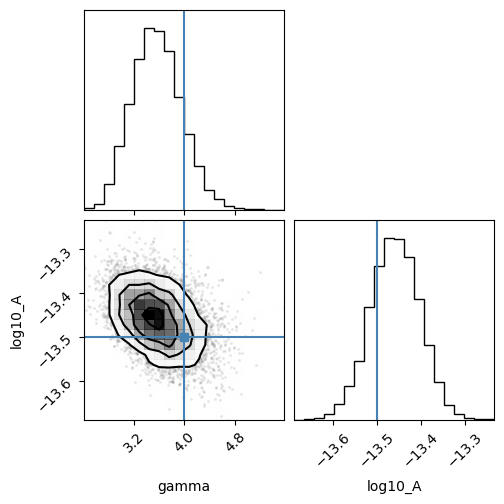

In [30]:
fig = corner.corner(
    burned_chain, 
    labels=["gamma", "log10_A"], 
    truths=[m_plrn.TNDMGAM.value, m_plrn.TNDMAMP.value],
)

In [31]:
gamma_e, log10_A_e = np.median(burned_chain, axis=0)

m_ent = deepcopy(m_plrn)
m_ent.TNDMAMP.value = log10_A_e
m_ent.TNDMGAM.value = gamma_e
P_ent = m_ent.components["PLDMNoise"].get_noise_weights(t)

In [32]:
f0 = (1/Tspan).to_value("Hz")

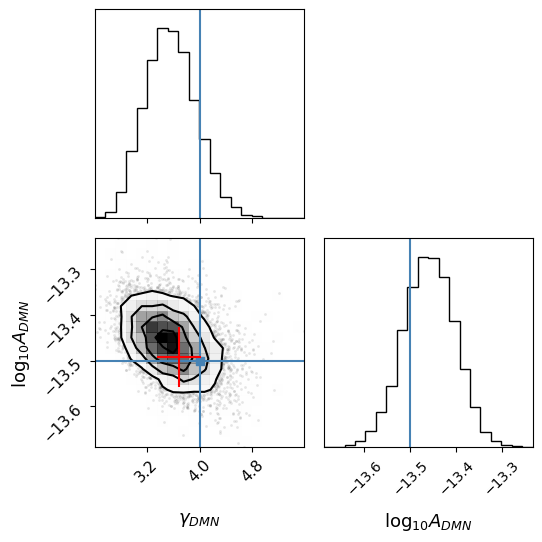

In [35]:
fig = corner.corner(
    burned_chain, 
    labels=["$\\gamma_{DMN}$", "$\\log_{10} A_{DMN}$"], 
    truths=[m_plrn.TNDMGAM.value, m_plrn.TNDMAMP.value],
    label_kwargs={"fontsize": 13}
)

plt.subplot(223)
plt.errorbar([m_pint.TNDMGAM.value], [m_pint.TNDMAMP.value], xerr=[m_pint.TNDMGAM.uncertainty_value], yerr=[m_pint.TNDMAMP.uncertainty_value], color="red")

plt.subplot(223)
plt.tick_params(axis="both", labelsize=11)

plt.tight_layout()

plt.savefig("sim4-param.pdf")

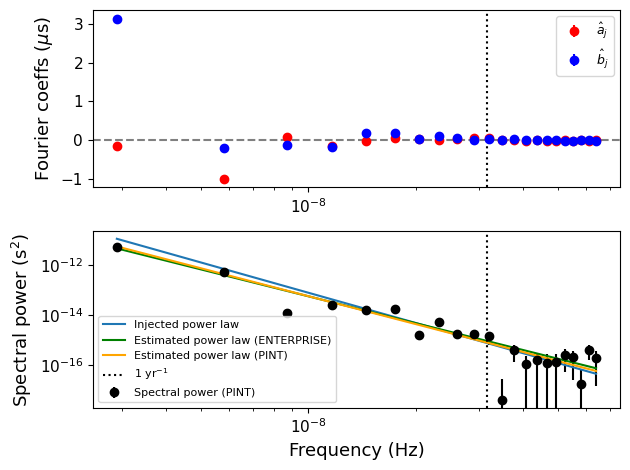

In [42]:
f0 = (1/Tspan).to_value("Hz")
fyr = (1 / u.year).to_value("Hz")

plt.subplot(211)
plt.errorbar(idxs*f0, b*1e6, db*1e6, ls="", marker="o", label="$\\hat{a}_j$", color="red")
plt.errorbar(idxs*f0, a*1e6, da*1e6, ls="", marker="o", label="$\\hat{b}_j$", color="blue")
plt.axvline(fyr, color="black", ls="dotted")
plt.axhline(0, color="grey", ls="--")
plt.ylabel("Fourier coeffs ($\mu$s)", fontsize=13)
plt.xscale("log")
plt.legend(fontsize=9)
plt.tick_params(axis="both", labelsize=11)


plt.subplot(212)
plt.errorbar(idxs*f0, P, dP, ls="", marker="o", label="Spectral power (PINT)", color="k")
plt.plot(idxs*f0, P_plrn[::2][:nharm_opt], label="Injected power law")
plt.plot(idxs*f0, P_ent[::2][:nharm_opt], label="Estimated power law (ENTERPRISE)", color="green")
plt.plot(idxs*f0, P_pint[::2][:nharm_opt], label="Estimated power law (PINT)", color="orange")
plt.axvline(fyr, color="black", ls="dotted", label="1 yr$^{-1}$")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Spectral power (s$^2$)", fontsize=13)
plt.xlabel("Frequency (Hz)", fontsize=13)
plt.legend(fontsize=8)
plt.tick_params(axis="both", labelsize=11)

plt.tight_layout()

plt.savefig("sim4-spec.pdf")

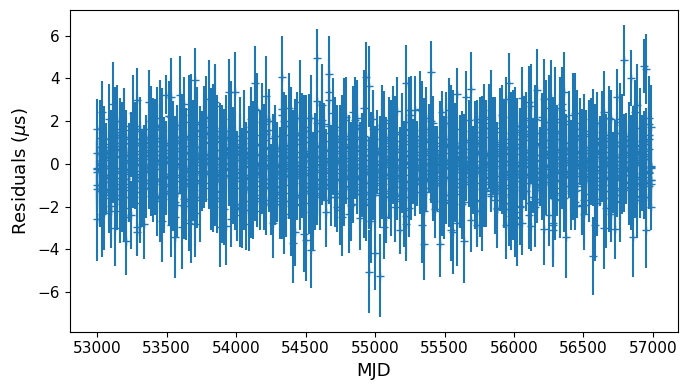

In [43]:
plt.figure(figsize=(7, 4))
plt.errorbar(ftr.toas.get_mjds(), ftr.resids.time_resids.to("us"), ftr.resids.get_data_error().to("us"), ls="", marker="+")
plt.ylabel("Residuals ($\\mu$s)", fontsize=13)
plt.xlabel("MJD", fontsize=13)
plt.tick_params(axis="both", labelsize=11)
plt.tight_layout()
plt.savefig("sim4-resids.pdf")